In [65]:
from scipy.integrate import solve_ivp
import numpy as np 
import matplotlib.pyplot as plt 
from math import floor, ceil, exp
from timeit import default_timer as timer


In [66]:
thrashing_nfev = 0
thrashings = []

measures_implemented = False
direction = "up"
def model_with_if(t, y):
    global thrashing_nfev
    thrashing_nfev += 1
    thrashings.append( (t, thrashing_nfev) )

    (S, E, I, R) = y
    global measures_implemented, direction
    N = 37.741 * (10**6)
    alpha = 1.0/8.0
    if (direction == "up"):
        if (E > 25000):
            #print("switched to True")
            measures_implemented = True
            direction = "down"
    else:
        if (E < 10000):
            #print("switched to false")
            measures_implemented = False
            direction = "up"

    beta = 0.005 if measures_implemented else 0.9
    gamma = 0.06
    mu = 0.01/365

    #print(E, beta)

    dSdt = mu*N - mu*S - (beta/N)*I*S
    dEdt = (beta/N)*I*S - alpha*E - mu*E
    dIdt = alpha*E - gamma*I - mu*I
    dRdt = gamma*I - mu*R

    return (dSdt, dEdt, dIdt, dRdt)

In [67]:
def model_no_measures(t, y):
    global thrashing_nfev
    thrashing_nfev += 1
    thrashings.append( (t, thrashing_nfev) )

    (S, E, I, R) = y

    N = 37.741 * 10**6
    alpha = 1.0/8.0
    beta = 0.9
    gamma = 0.06
    mu = 0.01/365

    dSdt = mu*N - mu*S - (beta/N)*I*S
    dEdt = (beta/N)*I*S - alpha*E - mu*E
    dIdt = alpha*E - gamma*I - mu*I
    dRdt = gamma*I - mu*R
    return (dSdt, dEdt, dIdt, dRdt)

def root_25000(_, y):
    E = y[1]
    return E - 25000
root_25000.terminal = True

def model_with_measures(t, y):
    global thrashing_nfev
    thrashing_nfev += 1
    thrashings.append( (t, thrashing_nfev) )

    (S, E, I, R) = y

    N = 37.741* (10**6)
    alpha = 1.0/8.0
    beta = 0.005
    gamma = 0.06
    mu = 0.01/365

    dSdt = mu*N - mu*S - (beta/N)*I*S
    dEdt = (beta/N)*I*S - alpha*E - mu*E
    dIdt = alpha*E - gamma*I - mu*I
    dRdt = gamma*I - mu*R

    return (dSdt, dEdt, dIdt, dRdt)

def root_10000(_, y):
    E = y[1]
    return E - 10000
root_10000.terminal = True

def experiment_event_detection(method):
    global thrashing_nfev, thrashings
    thrashing_nfev = 0
    thrashings = []

    N = 37.741 * (10**6)
    E0 = 103
    I0 = 1
    R0 = 0
    S0 = N - (E0 + I0 + R0)
    y0 = (S0, E0, I0, R0)
    t0 = 0

    res = np.array([[], [], [], []])
    times = np.array([])
    t_initial = t0
    y_initial = y0
    measures_implemented = False
    count_number_evaluations = 0
    time_elapsed = 0
    while t_initial < 180:
        tspan = [t_initial, 180]
        sol, start, end = None, None, None
        if (measures_implemented):
            start = timer()
            sol = solve_ivp(model_with_measures, tspan, y_initial, events=root_10000, dense_output=True, method=method)
            end = timer()
            measures_implemented = False
        else:
            start = timer()
            sol = solve_ivp(model_no_measures, tspan, y_initial, events=root_25000, dense_output=True, method=method)
            end = timer()
            measures_implemented = True
        t_event = 180 if len(sol.t_events[0]) == 0 else sol.t_events[0][0]
        t_calc = np.arange(t_initial, t_event, 1)
        y_cal = sol.sol(t_calc)
        res = np.concatenate((res, y_cal), axis=1)
        times = np.concatenate((times, t_calc))
        t_initial = t_event
        last_index = len(sol.y[0]) - 1
        y_initial = [sol.y[0][last_index], sol.y[1][last_index], sol.y[2][last_index], sol.y[3][last_index]]
        count_number_evaluations += sol.nfev
        time_elapsed += (end - start)
    
    
    times_thrashing = [thrashing[0] for thrashing in thrashings]
    nfev_thrashing = [thrashing[1] for thrashing in thrashings]
    plt.plot(times_thrashing, nfev_thrashing, label="nfev")
    plt.xlabel('time')
    plt.ylabel("cumulative nfev")
    plt.title(f"Thrashing without disc hand - {method}")
    plt.legend()
    plt.show()

    return (times, res, count_number_evaluations, time_elapsed)

# (times_lsoda, res_lsoda, nfev_lsoda, elapsed_lsoda) = experiment_event_detection("LSODA")
# (times_rk45, res_rk45, nfev_rk45, elapsed_rk45) = experiment_event_detection('RK45')
# (times_bdf, res_bdf, nfev_bdf, elapsed_bdf) = experiment_event_detection('BDF')
# (times_radau, res_radau, nfev_radau, elapsed_radau) = experiment_event_detection('Radau')
# (times_dop853, res_dop853, nfev_dop853, elapsed_dop853) = experiment_event_detection('DOP853')
# (times_rk23, res_rk23, nfev_rk23, elapsed_rk23) = experiment_event_detection('RK23')

# plt.plot(times_lsoda, res_lsoda[1])
# plt.plot(times_bdf, res_bdf[1])
# plt.plot(times_radau, res_radau[1])
# plt.plot(times_rk45, res_rk45[1])
# plt.plot(times_dop853, res_dop853[1])
# plt.plot(times_rk23, res_rk23[1])
# plt.ylabel("E(t)")
# plt.xlabel('time')
# plt.legend(['lsoda', 'bdf', 'radau', 'rk45', 'dop853', 'rk23'], shadow=True)
# plt.show()


# print(f"lsoda & {nfev_lsoda} & {elapsed_lsoda}")
# print(f"bdf & {nfev_bdf} & {elapsed_bdf}")
# print(f"radau & {nfev_radau} & {elapsed_radau}")
# print(f"rk45 & {nfev_rk45} & {elapsed_rk45}")
# print(f"dop853 & {nfev_dop853} & {elapsed_dop853}")
# print(f"rk23 & {nfev_rk23} & {elapsed_rk23}")

In [68]:

def experiment_with_if(method):
    global thrashing_nfev, thrashings
    thrashing_nfev = 0
    thrashings = []

    N = 37.741 * (10**6)
    E0 = 103
    I0 = 1
    R0 = 0
    S0 = N - (E0 + I0 + R0)
    y0 = (S0, E0, I0, R0)
    tspan = [0, 180]
    t_eval = np.linspace(0, 180, 181)
    global measures_implemented, direction
    measures_implemented = False
    direction = "up"
    start = timer()
    sol = solve_ivp(model_with_if, tspan, y0,
            method=method, t_eval=t_eval)
    end = timer()

    
    times_thrashing = [thrashing[0] for thrashing in thrashings]
    nfev_thrashing = [thrashing[1] for thrashing in thrashings]
    plt.plot(times_thrashing, nfev_thrashing, label="nfev")
    plt.xlabel('time')
    plt.ylabel("cumulative nfev")
    plt.title(f"Thrashing without disc hand - {method}")
    plt.legend()
    plt.show()

    return t_eval, sol.y, sol.nfev, end-start



In [69]:


def high_accuracy():
    N = 37.741 * (10**6)
    E0 = 103
    I0 = 1
    R0 = 0
    S0 = N - (E0 + I0 + R0)
    y0 = (S0, E0, I0, R0)
    t0 = 0

    res = np.array([[], [], [], []])
    times = np.array([])
    t_initial = t0
    y_initial = y0
    measures_implemented = False
    count_number_evaluations = 0
    time_elapsed = 0
    while t_initial < 180:
        tspan = [t_initial, 180]
        sol, start, end = None, None, None
        if (measures_implemented):
            start = timer()
            sol = solve_ivp(model_with_measures, tspan, y_initial, events=root_10000, dense_output=True, atol=1e-12, rtol=1e-12)
            end = timer()
            measures_implemented = False
        else:
            start = timer()
            sol = solve_ivp(model_no_measures, tspan, y_initial, events=root_25000, dense_output=True, atol=1e-12, rtol=1e-12)
            end = timer()
            measures_implemented = True
        t_event = 180 if len(sol.t_events[0]) == 0 else sol.t_events[0][0]
        t_calc = np.arange(t_initial, t_event, 1)
        y_cal = sol.sol(t_calc)
        res = np.concatenate((res, y_cal), axis=1)
        times = np.concatenate((times, t_calc))
        t_initial = t_event
        last_index = len(sol.y[0]) - 1
        y_initial = [sol.y[0][last_index], sol.y[1][last_index], sol.y[2][last_index], sol.y[3][last_index]]
        count_number_evaluations += sol.nfev
        time_elapsed += (end - start)
    return (times, res, count_number_evaluations, time_elapsed, [])

(times_high, res_high, nfev_high, elapsed_high, time_changes) = high_accuracy()

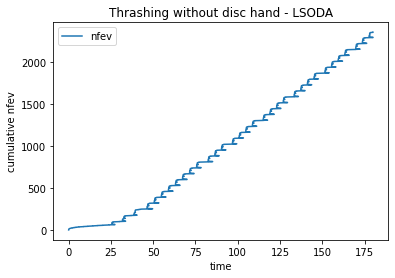

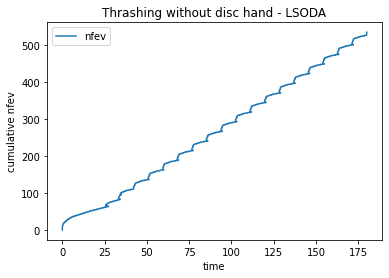

In [70]:
(times_lsoda_if, res_lsoda_if, nfev_lsoda_if, elapsed_lsoda_if) = experiment_with_if('LSODA')
(times_lsoda, res_lsoda, nfev_lsoda, elapsed_lsoda) = experiment_event_detection("LSODA")


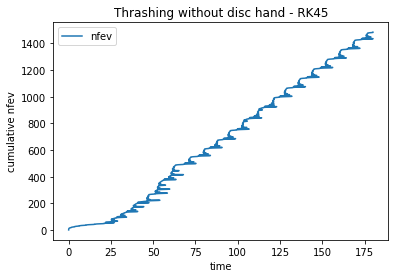

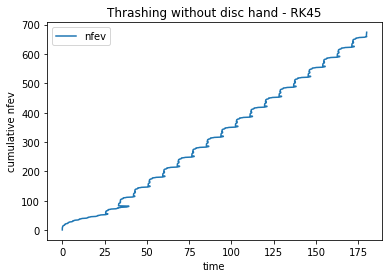

In [71]:
(times_rk45_if, res_rk45_if, nfev_rk45_if, elapsed_rk45_if) = experiment_with_if('RK45')
(times_rk45, res_rk45, nfev_rk45, elapsed_rk45) = experiment_event_detection("RK45")

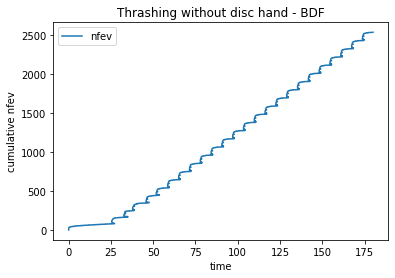

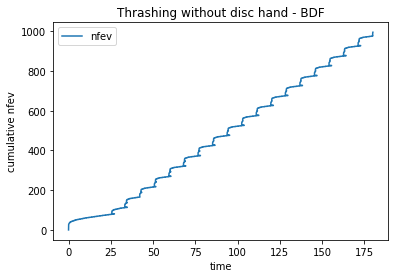

In [72]:
(times_bdf_if, res_bdf_if, nfev_bdf_if, elapsed_bdf_if) = experiment_with_if('BDF')
(times_bdf, res_bdf, nfev_bdf, elapsed_bdf) = experiment_event_detection("BDF")


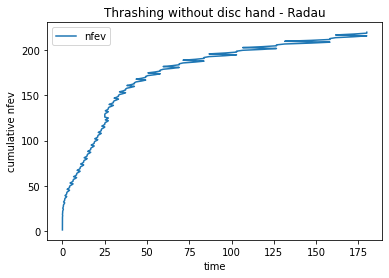

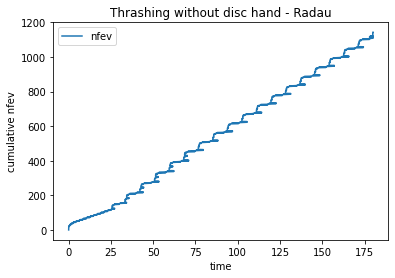

In [73]:
(times_radau_if, res_radau_if, nfev_radau_if, elapsed_radau_if) = experiment_with_if('Radau')
(times_radau, res_radau, nfev_radau, elapsed_radau) = experiment_event_detection("Radau")

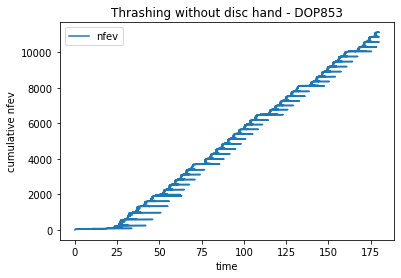

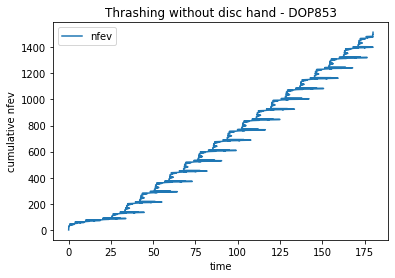

In [74]:
(times_dop853_if, res_dop853_if, nfev_dop853_if, elapsed_dop853_if) = experiment_with_if('DOP853')
(times_dop853, res_dop853, nfev_dop853, elapsed_dop853) = experiment_event_detection("DOP853")

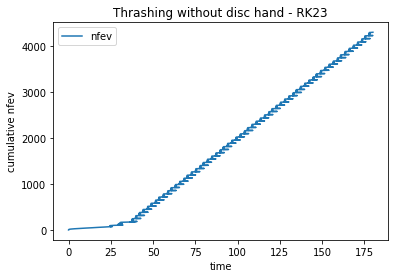

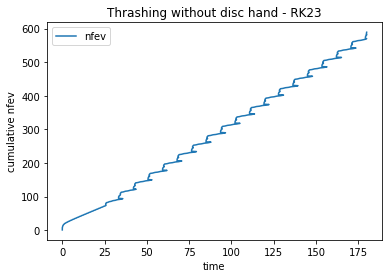

In [75]:
(times_rk23_if, res_rk23_if, nfev_rk23_if, elapsed_rk23_if) = experiment_with_if('RK23')
(times_rk23, res_rk23, nfev_rk23, elapsed_rk23) = experiment_event_detection("RK23")

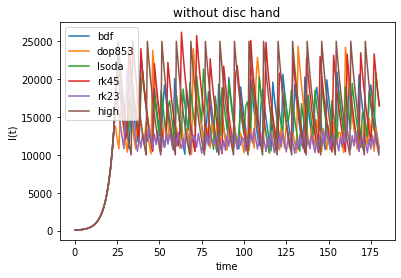

lsoda & 2357 & 0.020567099999993843 \\
rk45 & 1484 & 0.01923960000004854 \\
bdf & 2301 & 0.1386865000000057 \\
radau & 211 & 0.00865640000000667 \\
dop853 & 11129 & 0.09972989999999982 \\
rk23 & 4307 & 0.05767559999998184 \\
high & 11858 & 0.16090740000015558 \\


In [76]:
plt.plot(times_bdf_if    , res_bdf_if[1], label="bdf")
plt.plot(times_dop853_if , res_dop853_if[1], label="dop853")
plt.plot(times_lsoda_if  , res_lsoda_if[1], label="lsoda")
plt.plot(times_rk45_if   , res_rk45_if[1], label="rk45")
plt.plot(times_rk23_if   , res_rk23_if[1], label="rk23")
plt.plot(times_high      , res_high[1], label="high")
plt.xlabel('time')
plt.ylabel("I(t)")
plt.title(f"without disc hand")
plt.legend()
plt.show()

print(f"lsoda & {nfev_lsoda_if} & {elapsed_lsoda_if} \\\\")
print(f"rk45 & {nfev_rk45_if} & {elapsed_rk45_if} \\\\")
print(f"bdf & {nfev_bdf_if} & {elapsed_bdf_if} \\\\")
print(f"radau & {nfev_radau_if} & {elapsed_radau_if} \\\\")
print(f"dop853 & {nfev_dop853_if} & {elapsed_dop853_if} \\\\")
print(f"rk23 & {nfev_rk23_if} & {elapsed_rk23_if} \\\\")
print(f"high & {nfev_high} & {elapsed_high} \\\\")

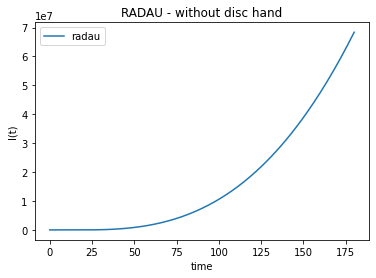

In [77]:
plt.plot(times_radau_if  , res_radau_if[1], label="radau")
plt.xlabel('time')
plt.ylabel("I(t)")
plt.title(f"RADAU - without disc hand")
plt.legend()
plt.show()


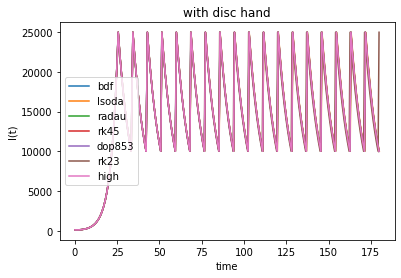

lsoda & 535 & 0.014906999999993786 \\
rk45 & 674 & 0.017153300000188665 \\
bdf & 808 & 0.06656129999993254 \\
radau & 990 & 0.04072899999988522 \\
dop853 & 1514 & 0.02845640000015237 \\
rk23 & 589 & 0.01939930000003187 \\
high & 11858 & 0.16090740000015558 \\


In [78]:
plt.plot(times_bdf    , res_bdf[1], label="bdf")
plt.plot(times_lsoda  , res_lsoda[1], label="lsoda")
plt.plot(times_radau  , res_radau[1], label="radau")
plt.plot(times_rk45   , res_rk45[1], label="rk45")
plt.plot(times_dop853 , res_dop853[1], label="dop853")
plt.plot(times_rk23   , res_rk23[1], label="rk23")
plt.plot(times_high   , res_high[1], label="high")
plt.xlabel('time')
plt.ylabel("I(t)")
plt.title(f"with disc hand")
plt.legend()
plt.show()

print(f"lsoda & {nfev_lsoda} & {elapsed_lsoda} \\\\")
print(f"rk45 & {nfev_rk45} & {elapsed_rk45} \\\\")
print(f"bdf & {nfev_bdf} & {elapsed_bdf} \\\\")
print(f"radau & {nfev_radau} & {elapsed_radau} \\\\")
print(f"dop853 & {nfev_dop853} & {elapsed_dop853} \\\\")
print(f"rk23 & {nfev_rk23} & {elapsed_rk23} \\\\")
print(f"high & {nfev_high} & {elapsed_high} \\\\")